# Notebook to get qhat in David's approach

### Simulation parameters

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 1         
N = 128
# N = 512
tau_sim = 0.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS

# Glasma fields
su_group = 'su3'
uv = 10.0
ir = 0.2
g2mu = 1.5

g = 2         		
mu = g2mu / g**2

ns = 50      

nevents = 1

### Enviroment variables

In [3]:
import os

# Comment this, I need it for JYU GPUs to choose a specific GPU to run on
# os.environ["CUDA_VISIBLE_DEVICES"]="4,5,7"

# os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Qhat module
import curraun.qhat as qhat
import curraun.qhat_qeik as qhat_qeik

import pickle
from tqdm import tqdm

In [4]:
def simulate_qhat(ev): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Qhat module
    qhat_qeik_tforce = qhat_qeik.KineticCanonicCheck(s)  
    xplus = []
    deltapsq, deltapisq, deltaasq, deltapdeltaa, deltaasq_transp = [], [], [], [], []

    if use_cuda:
        qhat_qeik_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)
            
            qhat_qeik_tforce.compute()

            # Compute momentum broadening from Qhat module
            if t % DTS == 0:
                if use_cuda:
                    qhat_qeik_tforce.copy_to_host()

                # Units GeV^2
                deltapsq.append(qhat_qeik_tforce.deltapsq_mean * E0 ** 2)
                deltapisq.append(qhat_qeik_tforce.deltapisq_mean * E0 ** 2)
                deltaasq.append(qhat_qeik_tforce.deltaasq_mean * E0 ** 2)
                deltaasq_transp.append(qhat_qeik_tforce.deltaasq_transp_mean * E0 ** 2)
                deltapdeltaa.append(qhat_qeik_tforce.deltapdeltaa_mean * E0 ** 2)
                # Units GeV^-1
                xplus.append(2*t*a/DTS/hbarc)


            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return xplus, deltapsq, deltapisq, deltaasq, deltapdeltaa, deltaasq_transp

In [5]:
collect_deltapsq, collect_deltapisq, collect_deltaasq, collect_deltapdeltaa, collect_deltaasq_transp = [], [], [], [], []

for ev in range(nevents):
    xplus, deltapsq_ev, deltapisq_ev, deltaasq_ev, deltapdeltaa_ev, deltaasq_transp_ev = simulate_qhat(ev)
   
    collect_deltapsq.append(deltapsq_ev)
    collect_deltapisq.append(deltapisq_ev)
    collect_deltaasq.append(deltaasq_ev)
    collect_deltapdeltaa.append(deltapdeltaa_ev)    
    collect_deltaasq_transp.append(deltaasq_transp_ev)

deltapsq = np.mean(collect_deltapsq, axis=0)
deltapisq = np.mean(collect_deltapisq, axis=0)
deltaasq = np.mean(collect_deltaasq, axis=0)
deltapdeltaa = np.mean(collect_deltapdeltaa, axis=0)    
deltaasq_transp = np.mean(collect_deltaasq_transp, axis=0)

Event 1: 100%|██████████| 256/256 [01:09<00:00,  3.68it/s]


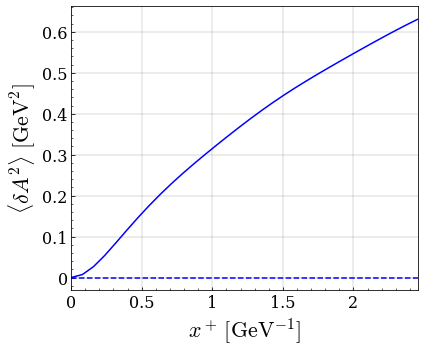

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', which='major', direction='in')
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', direction='in')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

i = 2
line1, = plt.plot(xplus, deltaasq[:, i], linewidth=1.5, color='blue')
line2, = plt.plot(xplus, deltaasq_transp[:, i], linewidth=1.5, color='blue', linestyle='--')

plt.xlim([0, max(xplus)])
# plt.ylim([min(pzAz_sq)*1.6, max(mom_broad_qeik[:, 2]/3)*2])
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

plt.xlabel(r"$x^+\,\mathrm{[GeV^{-1}]}$", fontsize=22)
plt.ylabel(r"$\langle \delta A^2\rangle\,\,\mathrm{[GeV^2]}$", fontsize=22)

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

# legend2 = plt.legend([line1, line2, line3, line4], [r"$\langle \delta\pi_{y}\rangle$", r"$\langle \delta p_{y}\rangle$", r"$\langle \delta A_y\rangle$", r"$\langle \delta p_y\rangle - \langle \delta A_y\rangle$"], fontsize=18, frameon=False, ncol=2, loc='upper left', title_fontsize=20)

plt.tight_layout()
# plt.savefig('delta_pi_p_A_y_1_ev_t1.png', facecolor='w', dpi=600) 

plt.show()

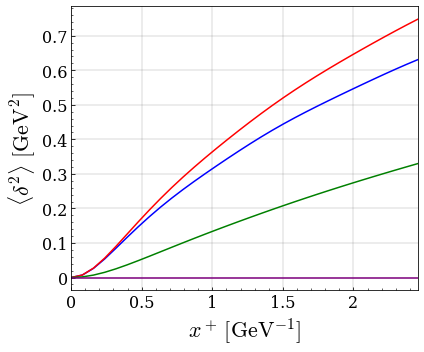

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', which='major', direction='in')
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', direction='in')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

i = 2
line1, = plt.plot(xplus, deltaasq[:, i], linewidth=1.5, color='blue')
line2, = plt.plot(xplus, deltapisq[:, i], linewidth=1.5, color='red')
line3, = plt.plot(xplus, deltapsq[:, i], linewidth=1.5, color='green')
line4, = plt.plot(xplus, deltapdeltaa[:, i], linewidth=1.5, color='purple')

plt.xlim([0, max(xplus)])
# plt.ylim([min(pzAz_sq)*1.6, max(mom_broad_qeik[:, 2]/3)*2])
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

plt.xlabel(r"$x^+\,\mathrm{[GeV^{-1}]}$", fontsize=22)
plt.ylabel(r"$\langle \delta^2\rangle\,\,\mathrm{[GeV^2]}$", fontsize=22)

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

# legend2 = plt.legend([line1, line2, line3, line4], [r"$\langle \delta\pi_{y}\rangle$", r"$\langle \delta p_{y}\rangle$", r"$\langle \delta A_y\rangle$", r"$\langle \delta p_y\rangle - \langle \delta A_y\rangle$"], fontsize=18, frameon=False, ncol=2, loc='upper left', title_fontsize=20)

plt.tight_layout()
# plt.savefig('delta_pi_p_A_y_1_ev_t1.png', facecolor='w', dpi=600) 

plt.show()

---

### We simulate the events

In [3]:
def simulate_qhat(ev): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    # Same event #TODO: Remove this later
    mv.set_seed(1)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Qhat module
    qhat_tforce = qhat.TransportedForce(s)
    qhat_qeik_tforce = qhat_qeik.TransportedForce(s)  
    # xplus = []
    mom_broad, xplus =  [], []
    mom_broad_qeik =  []
    # az_sq, ay_sq = [], []
    # pzAz_sq, pyAy_sq = [], []
    ai_sq = []
    pAi = []
    deltapi, deltap, deltaA = [], [], []
    deltapi_latt, deltap_latt, deltaA_latt = [], [], []
    latt = 3

    if use_cuda:
        qhat_tforce.copy_to_device()
        qhat_qeik_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)
            
            qhat_tforce.compute()
            qhat_qeik_tforce.compute()


            # Compute momentum broadening from Qhat module
            if t % DTS == 0:
                if use_cuda:
                    qhat_tforce.copy_mean_to_host()
                    # qhat_qeik_tforce.copy_mean_to_host()
                    qhat_qeik_tforce.copy_to_host()

                # Units GeV^2
                mom_broad.append(qhat_tforce.p_perp_mean * E0 ** 2)
                mom_broad_qeik.append(qhat_qeik_tforce.p_perp_mean * E0 ** 2)
                # Units GeV^-1
                xplus.append(2*t*a/DTS/hbarc)

                # az_sq.append(qhat_qeik_tforce.az_sq_mean * E0 ** 2)
                # ay_sq.append(qhat_qeik_tforce.ay_sq_mean * E0 ** 2)

                ai_sq.append(qhat_qeik_tforce.ai_sq_mean * E0 ** 2)
                # ai_sq.append(qhat_qeik_tforce.delta_ai * E0 ** 2)

                # pzAz_sq.append(qhat_qeik_tforce.p_perp_A_mean[1] * E0 ** 2)
                # pyAy_sq.append(qhat_qeik_tforce.p_perp_A_mean[2] * E0 ** 2)

                pAi.append(qhat_qeik_tforce.p_perp_A_mean * E0 ** 2)

                deltapi.append(qhat_qeik_tforce.deltapi_mean * E0)
                deltap.append(qhat_qeik_tforce.deltap_mean * E0)
                deltaA.append(qhat_qeik_tforce.deltaA_mean * E0)

                deltapi_latt.append(qhat_qeik_tforce.deltapi * E0)
                deltap_latt.append(qhat_qeik_tforce.deltap * E0)
                deltaA_latt.append(qhat_qeik_tforce.deltaA * E0)
                
            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    # return mom_broad, mom_broad_qeik, ay_sq, az_sq, pzAz_sq, pyAy_sq, xplus
    # return mom_broad, mom_broad_qeik, ai_sq, pAi, xplus
    # return mom_broad, mom_broad_qeik, ai_sq, pAi, deltapi, deltap, deltaA, xplus
    return mom_broad, mom_broad_qeik, ai_sq, pAi, deltapi, deltap, deltaA, deltapi_latt, deltap_latt, deltaA_latt,  xplus
    # return mom_broad, mom_broad_qeik, xplus
    # return mom_broad_qeik, xplus

In [4]:
mom_broads = []
mom_broads_qeik = []
# az_sqs, ay_sqs = [], []
# pzAz_sqs, pyAy_sqs = [], []
ai_sqs = []
pAis = []
deltapis, deltaps, deltaAs = [], [], []

for ev in range(nevents):
    # mom_broad_ev, mom_broad_qeik_ev, ai_sq_ev, pAi_ev, xplus = simulate_qhat(ev)
    mom_broad_ev, mom_broad_qeik_ev, ai_sq_ev, pAi_ev, deltapi_ev, deltap_ev, deltaA_ev, deltapi_latt, deltap_latt, deltaA_latt, xplus = simulate_qhat(ev)
    # mom_broad_ev, mom_broad_qeik_ev, ay_sq_ev, az_sq_ev, pzAz_sq, pyAy_sq, xplus = simulate_qhat(ev)
    # mom_broad_ev, mom_broad_qeik_ev, xplus = simulate_qhat(ev)
    # mom_broad_qeik_ev, xplus = simulate_qhat(ev)
    mom_broads.append(mom_broad_ev)
    mom_broads_qeik.append(mom_broad_qeik_ev)
    # az_sqs.append(az_sq_ev)
    # ay_sqs.append(ay_sq_ev)
    # pzAz_sqs.append(pzAz_sq)
    # pyAy_sqs.append(pyAy_sq)
    ai_sqs.append(ai_sq_ev)
    pAis.append(pAi_ev)
    deltapis.append(deltapi_ev)
    deltaps.append(deltap_ev)
    deltaAs.append(deltaA_ev)

mom_broad = np.mean(mom_broads, axis=0)
mom_broad_qeik = np.mean(mom_broads_qeik, axis=0) 

# az_sq = np.mean(az_sqs, axis=0)
# ay_sq = np.mean(ay_sqs, axis=0)
# pzAz_sq = np.mean(pzAz_sqs, axis=0)
# pyAy_sq = np.mean(pyAy_sqs, axis=0)
ai_sq = np.mean(ai_sqs, axis=0)
pAi = np.mean(pAis, axis=0)
deltapi = np.mean(deltapis, axis=0)
deltap = np.mean(deltaps, axis=0)
deltaA = np.mean(deltaAs, axis=0)

Event 1: 100%|██████████| 1024/1024 [39:22<00:00,  2.31s/it] 


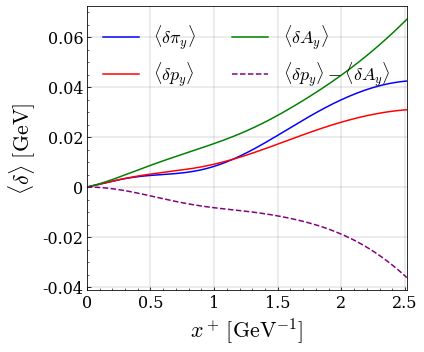

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', which='major', direction='in')
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', direction='in')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

line1, = plt.plot(xplus, deltapi[:, 1], linewidth=1.5, color='blue')
line2, = plt.plot(xplus, deltap[:, 2], linewidth=1.5, color='red')
# line3, = plt.plot(xplus, az_sq/3, linewidth=1.5, color='green')
line3, = plt.plot(xplus, deltaA[:, 1], linewidth=1.5, color='green')
line4, = plt.plot(xplus, deltap[:, 2] - deltaA[:, 1], linewidth=1.5, color='purple', linestyle='--')

# line5, = plt.plot(xplus, pzAz_sq/3, linewidth=1.5, color='orange')
# line5, = plt.plot(xplus, pAi[:, 2], linewidth=1.5, color='orange')

plt.xlim([0, max(xplus)])
# plt.ylim([min(pzAz_sq)*1.6, max(mom_broad_qeik[:, 2]/3)*2])
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

plt.xlabel(r"$x^+\,\mathrm{[GeV^{-1}]}$", fontsize=22)
plt.ylabel(r"$\langle \delta\rangle\,\,\mathrm{[GeV]}$", fontsize=22)

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

legend2 = plt.legend([line1, line2, line3, line4], [r"$\langle \delta\pi_{y}\rangle$", r"$\langle \delta p_{y}\rangle$", r"$\langle \delta A_y\rangle$", r"$\langle \delta p_y\rangle - \langle \delta A_y\rangle$"], fontsize=18, frameon=False, ncol=2, loc='upper left', title_fontsize=20)

plt.tight_layout()
plt.savefig('delta_pi_p_A_y_1_ev_t1.png', facecolor='w', dpi=600) 

plt.show()

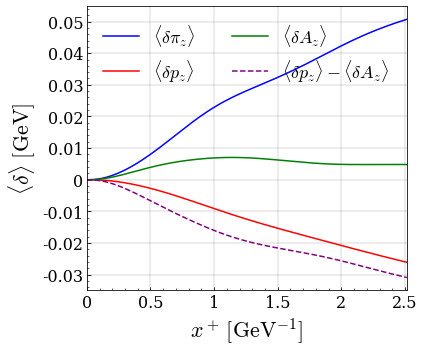

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', which='major', direction='in')
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', direction='in')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

line1, = plt.plot(xplus, deltapi[:, 2], linewidth=1.5, color='blue')
line2, = plt.plot(xplus, deltap[:, 1], linewidth=1.5, color='red')
# line3, = plt.plot(xplus, az_sq/3, linewidth=1.5, color='green')
line3, = plt.plot(xplus, deltaA[:, 2], linewidth=1.5, color='green')
line4, = plt.plot(xplus, deltap[:, 1] - deltaA[:, 2], linewidth=1.5, color='purple', linestyle='--')
# line5, = plt.plot(xplus, pzAz_sq/3, linewidth=1.5, color='orange')
# line5, = plt.plot(xplus, pAi[:, 2], linewidth=1.5, color='orange')

plt.xlim([0, max(xplus)])
# plt.ylim([min(pzAz_sq)*1.6, max(mom_broad_qeik[:, 2]/3)*2])
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

plt.xlabel(r"$x^+\,\mathrm{[GeV^{-1}]}$", fontsize=22)
plt.ylabel(r"$\langle \delta\rangle\,\,\mathrm{[GeV]}$", fontsize=22)

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

legend2 = plt.legend([line1, line2, line3, line4], [r"$\langle \delta\pi_{z}\rangle$", r"$\langle \delta p_{z}\rangle$", r"$\langle \delta A_z\rangle$", r"$\langle \delta p_z\rangle - \langle \delta A_z\rangle$"], fontsize=18, frameon=False, ncol=2, loc='upper left', title_fontsize=20)

plt.tight_layout()
plt.savefig('delta_pi_p_A_z_1_ev_t1.png', facecolor='w', dpi=600) 

plt.show()

### We plot the momentum broadening and qhat separately for z and y

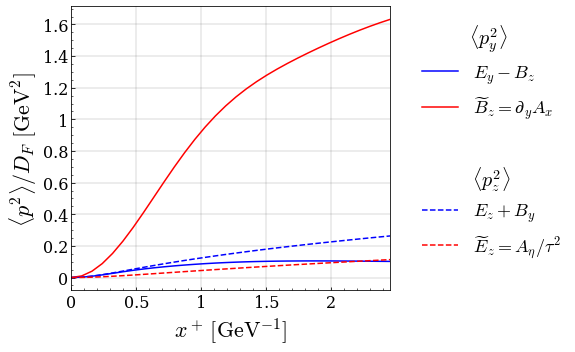

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(8, 5))

plt.tick_params(axis='both', which='major', direction='in')
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', direction='in')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

line1, = plt.plot(xplus, mom_broad[:, 1]/3, label=r"$E_y-B_z$", linewidth=1.5, color='blue')
# plt.plot(xplus, mom_broad_qeik[:, 2]/3, label=r"$B_z$", linewidth=1.5, color='purple')   
line2, = plt.plot(xplus, mom_broad_qeik[:, 0]/3, label=r"$\partial_y A_x$", linewidth=1.5, color='red')    
line3, = plt.plot(xplus, mom_broad[:, 2]/3, label=r"$E_z+B_y$", linewidth=1.5, color='blue', linestyle='--')
line4, = plt.plot(xplus, mom_broad_qeik[:, 1]/3, label=r"$A_\eta/\tau^2$", linewidth=1.5, color='red', linestyle='--')

plt.xlim([0, max(xplus)])
# plt.ylim([0, max(mom_broad_qeik[:, 0]/3)*1.1])
# plt.yticks([0, 0.5, 1, 1.5])
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

plt.xlabel(r"$x^+\,\mathrm{[GeV^{-1}]}$", fontsize=22)
plt.ylabel(r"$\langle p^2\rangle/D_F\,\,\mathrm{[GeV^{2}]}$", fontsize=22)

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

legend1 = plt.legend([line1, line2], [r"$E_y-B_z$", r"$\widetilde{B}_z=\partial_y A_x$"], title=r"$\langle p_{y}^2\rangle$", fontsize=18, frameon=False, ncol=1, loc='upper left', title_fontsize=20, bbox_to_anchor=(1.05, 1))
legend2 = plt.legend([line3, line4], [r"$E_z+B_y$", r"$\widetilde{E}_z=A_\eta/\tau^2$"], title=r"$\langle p_{z}^2\rangle$", fontsize=18, frameon=False, ncol=1, loc='upper left', title_fontsize=20, bbox_to_anchor=(1.05, 0.5))
plt.gca().add_artist(legend1)
plt.tight_layout(rect=[0, 0, 0.8, 1])

plt.tight_layout()
# plt.savefig('classical_vs_quantum_mom_broad_yz_more_events.png', facecolor='w', dpi=600)

plt.show()

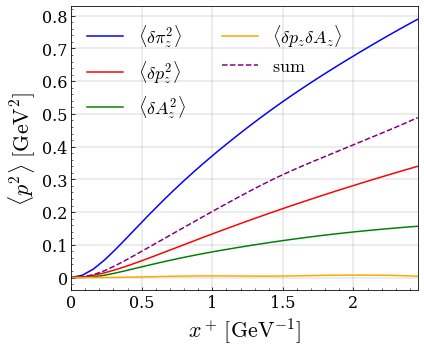

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', which='major', direction='in')
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', direction='in')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

line1, = plt.plot(xplus, mom_broad[:, 2], linewidth=1.5, color='blue')
line2, = plt.plot(xplus, mom_broad_qeik[:, 1], linewidth=1.5, color='red')
# line3, = plt.plot(xplus, az_sq/3, linewidth=1.5, color='green')
line3, = plt.plot(xplus, ai_sq[:, 2], linewidth=1.5, color='green')
line4, = plt.plot(xplus, mom_broad_qeik[:, 1] + ai_sq[:, 2] - 2*pAi[:, 2], linewidth=1.5, color='purple', linestyle='--')
# line5, = plt.plot(xplus, pzAz_sq/3, linewidth=1.5, color='orange')
line5, = plt.plot(xplus, pAi[:, 2], linewidth=1.5, color='orange')

plt.xlim([0, max(xplus)])
# plt.ylim([min(pzAz_sq)*1.6, max(mom_broad_qeik[:, 2]/3)*2])
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

plt.xlabel(r"$x^+\,\mathrm{[GeV^{-1}]}$", fontsize=22)
plt.ylabel(r"$\langle p^2\rangle\,\,\mathrm{[GeV^{2}]}$", fontsize=22)

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

legend2 = plt.legend([line1, line2, line3, line5, line4], [r"$\langle \delta\pi_{z}^2\rangle$", r"$\langle \delta p_{z}^2\rangle$", r"$\langle \delta A_z^2\rangle$", r"$\langle \delta p_z \delta A_z\rangle$", r"$\mathrm{sum}$"], fontsize=18, frameon=False, ncol=2, loc='upper left', title_fontsize=20)

plt.tight_layout()
# plt.savefig('kin_can_mom_z_more_events.png', facecolor='w', dpi=600) 

plt.show()

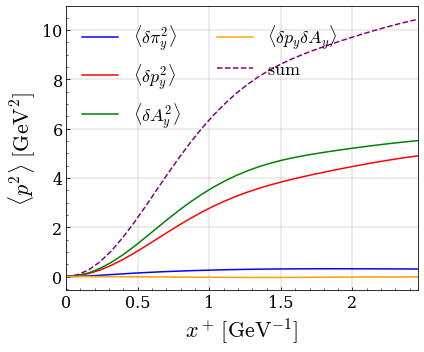

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', which='major', direction='in')
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', direction='in')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

line1, = plt.plot(xplus, mom_broad[:, 1], linewidth=1.5, color='blue')
line2, = plt.plot(xplus, mom_broad_qeik[:, 0], linewidth=1.5, color='red')
# line3, = plt.plot(xplus, az_sq/3, linewidth=1.5, color='green')
line3, = plt.plot(xplus, ai_sq[:, 1], linewidth=1.5, color='green')
line4, = plt.plot(xplus, mom_broad_qeik[:, 0] + ai_sq[:, 1] - 2*pAi[:, 1], linewidth=1.5, color='purple', linestyle='--')
# line5, = plt.plot(xplus, pzAz_sq/3, linewidth=1.5, color='orange')
line5, = plt.plot(xplus, pAi[:, 1], linewidth=1.5, color='orange')

plt.xlim([0, max(xplus)])
# plt.ylim([min(pzAz_sq)*1.6, max(mom_broad_qeik[:, 2]/3)*2])
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

plt.xlabel(r"$x^+\,\mathrm{[GeV^{-1}]}$", fontsize=22)
plt.ylabel(r"$\langle p^2\rangle\,\,\mathrm{[GeV^{2}]}$", fontsize=22)

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

legend2 = plt.legend([line1, line2, line3, line5, line4], [r"$\langle \delta\pi_{y}^2\rangle$", r"$\langle \delta p_{y}^2\rangle$", r"$\langle \delta A_y^2\rangle$", r"$\langle \delta p_y \delta A_y\rangle$", r"$\mathrm{sum}$"], fontsize=18, frameon=False, ncol=2, loc='upper left', title_fontsize=20)

plt.tight_layout()
# plt.savefig('kin_can_mom_z_more_events.png', facecolor='w', dpi=600) 

plt.show()

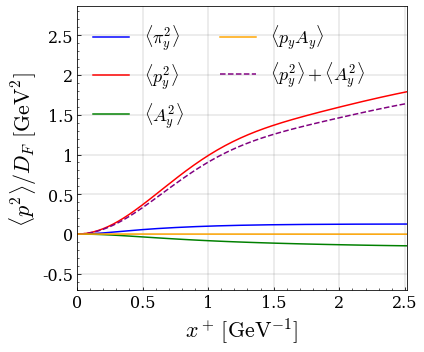

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', which='major', direction='in')
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', direction='in')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

line1, = plt.plot(xplus, mom_broad[:, 1]/3, linewidth=1.5, color='blue')
line2, = plt.plot(xplus, mom_broad_qeik[:, 0]/3, linewidth=1.5, color='red')

# line3, = plt.plot(xplus, (ay_sq-ay_sq[1])/3, linewidth=1.5, color='green')
# line4, = plt.plot(xplus, (ay_sq-ay_sq[1])/3 + mom_broad_qeik[:, 0]/3, linewidth=1.5, color='purple', linestyle='--')
# #TODO: investigate why the first point of ay_sq is 0
line3, = plt.plot(xplus[1:len(xplus)], (ay_sq[1:len(ay_sq)]-ay_sq[1])/3, linewidth=1.5, color='green')
line4, = plt.plot(xplus[1:len(xplus)], (ay_sq[1:len(ay_sq)]-ay_sq[1])/3 + mom_broad_qeik[1:len(mom_broad_qeik), 0]/3, linewidth=1.5, color='purple', linestyle='--')
line5, = plt.plot(xplus, pyAy_sq/3, linewidth=1.5, color='orange')

plt.xlim([0, max(xplus)])
plt.ylim([min((ay_sq[1:len(ay_sq)]-ay_sq[1]))*1.6, max(mom_broad_qeik[:, 0]/3)*1.6])
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

plt.xlabel(r"$x^+\,\mathrm{[GeV^{-1}]}$", fontsize=22)
plt.ylabel(r"$\langle p^2\rangle/D_F\,\,\mathrm{[GeV^{2}]}$", fontsize=22)

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

legend2 = plt.legend([line1, line2, line3, line5, line4], [r"$\langle \pi_{y}^2\rangle$", r"$\langle p_{y}^2\rangle$", r"$\langle A_y^2\rangle$", r"$\langle p_y A_y\rangle$", r"$\langle p_{y}^2\rangle+\langle A_y^2\rangle$"], fontsize=18, frameon=False, ncol=2, loc='upper left', title_fontsize=20)

plt.tight_layout()
# plt.savefig('kin_can_mom_y_more_events.png', facecolor='w', dpi=600)

plt.show()

---

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 1         
# N = 128
N = 512
tau_sim = 0.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS

# Glasma fields
su_group = 'su3'
uv = 10.0
ir = 0.2
g2mu = 1.5

g = 2         		
mu = g2mu / g**2

ns = 50      

nevents = 5

In [2]:
import os

# Comment this, I need it for JYU GPUs to choose a specific GPU to run on
os.environ["CUDA_VISIBLE_DEVICES"]="2,3,4"

# os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Qhat module
import curraun.qhat_fields as qhat_fields
import curraun.kappa as kappa
import curraun.kappa_qeik as kappa_qeik

import pickle
from tqdm import tqdm

Using CUDA
Using SU(3)
Using double precision


In [3]:
def simulate_qhat(ev): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Qhat module
    fields = qhat_fields.QhatFields(s)
    tau =  []
    # Esq, Bsq, Asq = np.zeros((maxt, 3), dtype=np.float64), np.zeros((maxt, 3), dtype=np.float64), np.zeros((maxt, 3), dtype=np.float64)
    Esq, Bsq, Asq = np.zeros((maxt//DTS, 3), dtype=np.float64), np.zeros((maxt//DTS, 3), dtype=np.float64), np.zeros((maxt//DTS, 3), dtype=np.float64)

    kappa_tforce = kappa.TransportedForce(s)
    kappa_qeik_tforce = kappa_qeik.TransportedForce(s)  
    mom_broad, mom_broad_qeik =  [], []
    tau_mom_broad = []

    if use_cuda:
        fields.copy_to_device()

    if use_cuda:
        kappa_tforce.copy_to_device()
        kappa_qeik_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            fields.compute()

            if t % DTS == 0:
                if use_cuda:
                    kappa_tforce.copy_mean_to_host()
                    kappa_qeik_tforce.copy_mean_to_host()

                # Units GeV^2
                mom_broad.append(kappa_tforce.p_perp_mean * E0 ** 2)
                mom_broad_qeik.append(kappa_qeik_tforce.p_perp_mean * E0 ** 2)

                # Units GeV^2
                Esq[t//DTS, :] = fields.Esq_mean * E0 ** 2
                Bsq[t//DTS, :] = fields.Bsq_mean * E0 ** 2
                Asq[t//DTS, :] = fields.Asq_mean * E0 ** 2
                tau.append(t*a/DTS)

            kappa_tforce.compute()
            kappa_qeik_tforce.compute()

            # Esq[t, :] = fields.Esq_mean * E0 ** 2
            # Bsq[t, :] = fields.Bsq_mean * E0 ** 2
            # Asq[t, :] = fields.Asq_mean * E0 ** 2
            # tau.append(t*a/DTS)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return Esq, Bsq, Asq, tau, mom_broad, mom_broad_qeik

In [4]:
Esq_all, Bsq_all, Asq_all = [], [], []
mom_broad_all, mom_broad_qeik_all = [], []
for ev in range(nevents):
    Esq, Bsq, Asq, tau, mom_broad, mom_broad_qeik = simulate_qhat(ev)
    Esq_all.append(Esq)
    Bsq_all.append(Bsq)
    Asq_all.append(Asq)
    mom_broad_all.append(mom_broad)
    mom_broad_qeik_all.append(mom_broad_qeik)

Esq = np.mean(np.array(Esq_all), axis=0)
Bsq = np.mean(np.array(Bsq_all), axis=0)
Asq = np.mean(np.array(Asq_all), axis=0)
mom_broad = np.mean(np.array(mom_broad_all), axis=0)
mom_broad_qeik = np.mean(np.array(mom_broad_qeik_all), axis=0)

  0%|          | 0/1024 [00:00<?, ?it/s]/n/work00/davrames/condacurraun/lib/python3.6/site-packages/numba/cuda/cudadrv/devicearray.py:496: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.copy_to_host().__array__(dtype)
Event 1:   1%|          | 8/1024 [00:11<18:31,  1.09s/it]  /n/work00/davrames/condacurraun/lib/python3.6/site-packages/numba/cuda/cudadrv/devicearray.py:496: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.copy_to_host().__array__(dtype)
Event 5: 100%|██████████| 1024/1024 [05:18<00:00,  3.22it/s]


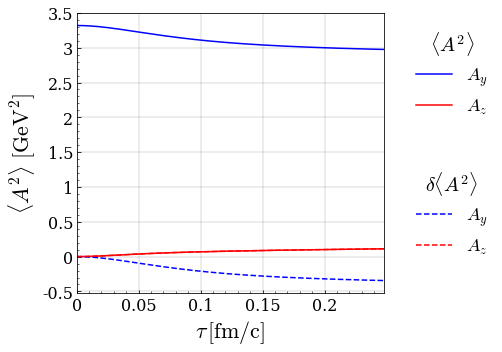

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(7, 5))

plt.tick_params(axis='both', which='major', direction='in')
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', direction='in')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

line1, = plt.plot(tau, Asq[:, 0], linewidth=1.5, color='blue')
line2, = plt.plot(tau, Asq[:, 1], linewidth=1.5, color='red')    
# line3, = plt.plot(tau, Asq[:, 2], linewidth=1.5, color='green') 

line4, = plt.plot(tau, Asq[:, 0]-Asq[0, 0], linewidth=1.5, color='blue', linestyle='--')
line5, = plt.plot(tau, Asq[:, 1]-Asq[0, 1], linewidth=1.5, color='red', linestyle='--')  

plt.xlim([0, max(tau)])

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

plt.xlabel(r"$\tau\,\mathrm{[fm/c]}$", fontsize=22)
plt.ylabel(r"$\langle A^2\rangle\,\,\mathrm{[GeV^{2}]}$", fontsize=22)

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

# legend1 = plt.legend([line1, line2, line3], [r"$A_y$", r"$A_z$", r"$A_\eta$"], title=r"$\langle A^2\rangle$", fontsize=18, frameon=False, ncol=1, loc='upper left', title_fontsize=20, bbox_to_anchor=(1.05, 1))
legend1 = plt.legend([line1, line2], [r"$A_y$", r"$A_z$"], title=r"$\langle A^2\rangle$", fontsize=18, frameon=False, ncol=1, loc='upper left', title_fontsize=20, bbox_to_anchor=(1.05, 1))

legend2 = plt.legend([line4, line5], [r"$A_y$", r"$A_z$"], title=r"$\delta\langle A^2\rangle$", fontsize=18, frameon=False, ncol=1, loc='upper left', title_fontsize=20, bbox_to_anchor=(1.05, 0.5))
plt.gca().add_artist(legend1)
plt.tight_layout(rect=[0, 0, 0.8, 1])

plt.tight_layout()
plt.savefig('absAsq_yz.png', facecolor='w', dpi=600)

plt.show()

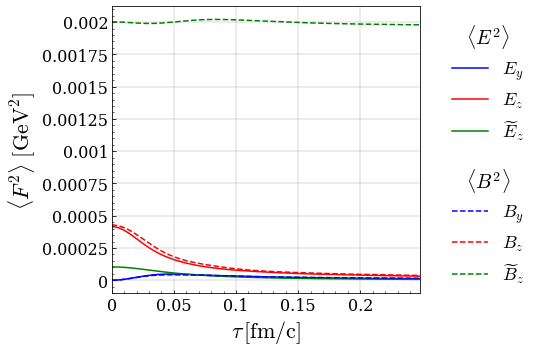

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(7.5, 5))

plt.tick_params(axis='both', which='major', direction='in')
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', direction='in')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

line1, = plt.plot(tau, Esq[:, 0], linewidth=1.5, color='blue')
line2, = plt.plot(tau, Esq[:, 1], linewidth=1.5, color='red')    
line3, = plt.plot(tau, Esq[:, 2], linewidth=1.5, color='green') 

line4, = plt.plot(tau, Bsq[:, 0], linewidth=1.5, color='blue', linestyle='--')
line5, = plt.plot(tau, Bsq[:, 1], linewidth=1.5, color='red', linestyle='--')    
line6, = plt.plot(tau, Bsq[:, 2], linewidth=1.5, color='green', linestyle='--') 

plt.xlim([0, max(tau)])

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

plt.xlabel(r"$\tau\,\mathrm{[fm/c]}$", fontsize=22)
plt.ylabel(r"$\langle F^2\rangle\,\,\mathrm{[GeV^{2}]}$", fontsize=22)

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

legend1 = plt.legend([line1, line2, line3], [r"$E_y$", r"$E_z$", r"$\widetilde{E}_z$"], title=r"$\langle E^2\rangle$", fontsize=18, frameon=False, ncol=1, loc='upper left', title_fontsize=20, bbox_to_anchor=(1.05, 1))

legend2 = plt.legend([line4, line5, line6], [r"$B_y$", r"$B_z$", r"$\widetilde{B}_z$"], title=r"$\langle B^2\rangle$", fontsize=18, frameon=False, ncol=1, loc='upper left', title_fontsize=20, bbox_to_anchor=(1.05, 0.5))
plt.gca().add_artist(legend1)
plt.tight_layout(rect=[0, 0, 0.8, 1])

plt.tight_layout()
plt.savefig('absEBsq_yz_kin_can.png', facecolor='w', dpi=600)

plt.show()

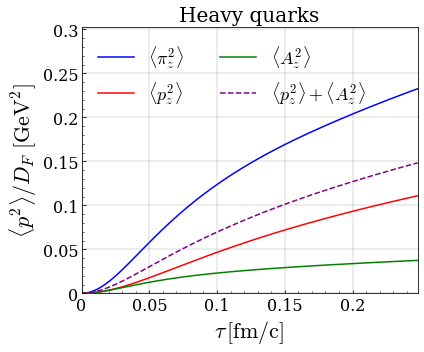

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', which='major', direction='in')
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', direction='in')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

line1, = plt.plot(tau, mom_broad[:, 2]/3, linewidth=1.5, color='blue')
line2, = plt.plot(tau, mom_broad_qeik[:, 2]/3, linewidth=1.5, color='red')
line3, = plt.plot(tau, Asq[:, 1]/3, linewidth=1.5, color='green')
line4, = plt.plot(tau, Asq[:, 1]/3 + mom_broad_qeik[:, 2]/3, linewidth=1.5, color='purple', linestyle='--')

plt.xlim([0, max(tau)])
plt.ylim([0, max(mom_broad[:, 2]/3)*1.3])
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

plt.xlabel(r"$\tau\,\mathrm{[fm/c]}$", fontsize=22)
plt.ylabel(r"$\langle p^2\rangle/D_F\,\,\mathrm{[GeV^{2}]}$", fontsize=22)

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)
plt.title(r"Heavy quarks", fontsize=20)

legend2 = plt.legend([line1, line2, line3, line4], [r"$\langle \pi_{z}^2\rangle$", r"$\langle p_{z}^2\rangle$", r"$\langle A_z^2\rangle$", r"$\langle p_{z}^2\rangle+\langle A_z^2\rangle$"], fontsize=18, frameon=False, ncol=2, loc='upper left', title_fontsize=20)

plt.tight_layout()
plt.savefig('kappa_kin_can_mom_z.png', facecolor='w', dpi=600)

plt.show()

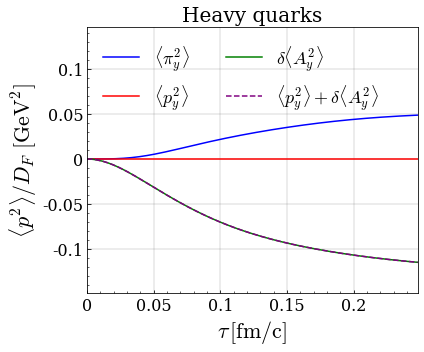

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', which='major', direction='in')
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', direction='in')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

line1, = plt.plot(tau, mom_broad[:, 1]/3, linewidth=1.5, color='blue')
line2, = plt.plot(tau, mom_broad_qeik[:, 1]/3, linewidth=1.5, color='red')
line3, = plt.plot(tau, (Asq[:, 0]-Asq[0, 0])/3, linewidth=1.5, color='green')
line4, = plt.plot(tau, (Asq[:, 0]-Asq[0, 0])/3 + mom_broad_qeik[:, 1]/3, linewidth=1.5, color='purple', linestyle='--')

plt.xlim([0, max(tau)])
plt.ylim([min((Asq[:, 0]-Asq[0, 0])/3)*1.3, max(mom_broad[:, 1]/3)*3])
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

plt.xlabel(r"$\tau\,\mathrm{[fm/c]}$", fontsize=22)
plt.ylabel(r"$\langle p^2\rangle/D_F\,\,\mathrm{[GeV^{2}]}$", fontsize=22)

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)
plt.title(r"Heavy quarks", fontsize=20)

legend2 = plt.legend([line1, line2, line3, line4], [r"$\langle \pi_{y}^2\rangle$", r"$\langle p_{y}^2\rangle$", r"$\delta\langle A_y^2\rangle$", r"$\langle p_{y}^2\rangle+\delta\langle A_y^2\rangle$"], fontsize=18, frameon=False, ncol=2, loc='upper left', title_fontsize=20)

plt.tight_layout()
plt.savefig('kappa_kin_can_mom_y.png', facecolor='w', dpi=600)

plt.show()

---

In [7]:
# We save to file

np.savetxt('Jets in Glasma Results/QM_results/classical_py.txt', [xplus, mom_broad_qeik[:, 0]/3], fmt='%f')

### Compute canonic $\hat{q}_y$

In [8]:
qhat = np.diff(mom_broad_qeik[:, 0]/3)/np.diff(xplus)

In [9]:
np.savetxt('Jets in Glasma Results/QM_results/classical_qy.txt', [xplus[1:len(xplus)], qhat], fmt='%f')